# Introduction


This notebook aims for providing an experiment of traditional pair trading with parameter autotuning grid search.

This experiment is based on [backtrader](https://www.backtrader.com/) which has an agnosticism philosophy that the data come in as a per-sample basis. Indicators are recalculate when new data come in.

And [Quantstat](https://github.com/ranaroussi/quantstats) for metrics and graphical analysis

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os, json, pickle
import numpy as np
import pandas as pd
import statsmodels.api as sm
import backtrader as bt
import quantstats as qs

from tqdm import tqdm
from itertools import combinations
# Find parameters in `params.py`
from params import *
from utils.deletion import clear_previous_res
from utils.gridsearch import gridsearch
from utils.read2df import read2df
from utils.cointncorr import CointnCorr
from utils.resanalyse import res_analyse
from utils.pyfolioprocess import pyfolio_process
from utils.rlmetrics import get_return, get_metrics
from envs.env_gridsearch import KellyCriterionIndicator, PairTrading

folder_path = "result/gridsearch"
os.makedirs(folder_path, exist_ok=True)

# Data Preparation

Load proper `symbols` and `freqs` from the analysis of `trade_preliminaries.ipynb`

Then is split for train data and test data from `start_date` until `trade_date`, and start trade after `trade_date`.

In [2]:
# Load from cointncorr pickle file
with open('result/cointncorr.pickle', 'rb') as pk:
    data = pickle.load(pk)

# dfs = read2df(symbols, freqs)
dfs = read2df(symbols=data[0], freqs={data[1]: freqs[data[1]]})

freq_position = list(freqs.keys()).index(data[1])

df0 = dfs[freq_position][dfs[freq_position]['tic']==data[0][0]].reset_index(drop=True)
df1 = dfs[freq_position][dfs[freq_position]['tic']==data[0][1]].reset_index(drop=True)

# Because we want to calculate profit based on BTC. Hence the price need to be changed.
df0 = df0[['time', 'close', 'volume', 'tic', 'itvl', 'datetime']]
df0['close'] = df0['close'].apply(lambda x: 1/x)

df1 = df1[['time', 'close', 'volume', 'tic', 'itvl', 'datetime']]
df1['close'] = df1['close'].apply(lambda x: 1/x)

pair, best_freq = data 
best_pair = f"{pair[0]}_{pair[1]}"

print("===========================================")
print(f"Data loaded as: {best_pair} under {best_freq} interval")
print("===========================================")

# have a preview
dfs[0].head(20)

Data loaded as: ETHEUR_ETHGBP under 1m interval


,time,open,high,low,close,volume,tic,itvl,datetime
0,1592560859999,207.15,207.15,207.15,207.15,0.00000,ETHEUR,1m,2020-06-19 10:00:59.999
1,1592560859999,184.44,184.44,184.44,184.44,0.05500,ETHGBP,1m,2020-06-19 10:00:59.999
2,1592560919999,207.15,207.15,207.15,207.15,0.00000,ETHEUR,1m,2020-06-19 10:01:59.999
3,1592560919999,184.78,184.78,184.78,184.78,0.68455,ETHGBP,1m,2020-06-19 10:01:59.999
4,1592560979999,207.15,207.15,207.15,207.15,0.00000,ETHEUR,1m,2020-06-19 10:02:59.999
5,1592560979999,184.78,184.78,184.78,184.78,0.00000,ETHGBP,1m,2020-06-19 10:02:59.999
6,1592561039999,206.00,206.00,206.00,206.00,0.18051,ETHEUR,1m,2020-06-19 10:03:59.999
7,1592561039999,184.78,184.78,184.78,184.78,0.00000,ETHGBP,1m,2020-06-19 10:03:59.999
8,1592561099999,206.00,206.00,206.00,206.00,0.00000,ETHEUR,1m,2020-06-19 10:04:59.999
9,1592561099999,184.78,184.78,184.78,184.78,0.00000,ETHGBP,1m,2020-06-19 10:04:59.999


In [3]:
'''
Set data before `trade_data` as training data, after `trade_data` is trade_data
'''

trains, tests = [], []
for i in range(len(dfs)):
    trains.append(dfs[i][(dfs[i]['datetime'] > start_date) & (dfs[i]['datetime'] < trade_date)].reset_index(drop=True))
    tests.append(dfs[i][dfs[i]['datetime'] >= trade_date].reset_index(drop=True))

# Cointegration and Correlation

We need to make sure that our data is capable for pair trading. 
At least it should have the tendency to merge together therefore we test the coint and corr between every possible two pairs 

Calculate daily coint and corr for all the pairs
Consider 1 day with 1440 minutes.

Delete the pickle file in the `\result` if want to recalculate

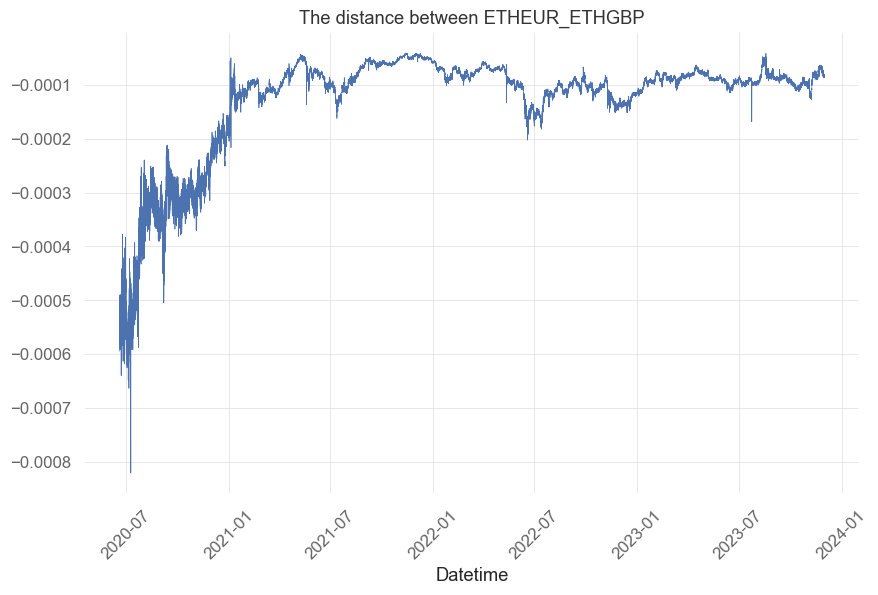

In [4]:
import matplotlib.pyplot as plt

distance = df0['close']-df1['close']
stddev = np.std(distance)

plt.plot(df0['datetime'], distance, linewidth=0.5)

# Set labels and title
plt.xlabel('Datetime')
plt.xticks(rotation=45) 

plt.title(f"The distance between {best_pair}")

# Display the plot
plt.show()

In [5]:
freq_pos = list(freqs.keys()).index(best_freq)

traindata0 = trains[freq_pos][trains[freq_pos]['tic']==best_pair.split('_')[0]].reset_index(drop=True)
traindata1 = trains[freq_pos][trains[freq_pos]['tic']==best_pair.split('_')[1]].reset_index(drop=True)

# How come a datetime of 2022(ish) is converted to 738786.635416655???
datafeed0 = bt.feeds.PandasData(
        dataname=traindata0,
        datetime='datetime',
        open='open',
        high='high',
        low='low',
        close='close',
        volume='volume',
        openinterest=None,
    )

datafeed1 = bt.feeds.PandasData(
        dataname=traindata1,
        datetime='datetime',
        open='open',
        high='high',
        low='low',
        close='close',
        volume='volume',
        openinterest=None,
    )

datafeeds = [datafeed0, datafeed1]
print(f"length of train set is {len(traindata0)}")

length of train set is 1331282


# Execute the Strategy

We should firstly have a test run on the strategy to make sure it works.

Submitted a PR for Backtrader-OLS results

> https://github.com/mementum/backtrader/pull/487

In [6]:
def cerebro_run(datafeeds, param):

    cerebro = bt.Cerebro()

    cerebro.adddata(datafeeds[0], name=best_pair.split('_')[0])
    cerebro.adddata(datafeeds[1], name=best_pair.split('_')[1])

    cerebro.broker.set_cash(1)  # Set initial capital

    # Binance fee structure
    # https://www.binance.com/en-BH/support/faq/binance-futures-fee-structure-fee-calculations-360033544231
    cerebro.broker.setcommission(commission=0.0002)

    # comminfo = PairTradingCommInfo(commission=0.002, margin=1000, mult=10)
    # cerebro.broker.addcommissioninfo(comminfo)

    cerebro.addanalyzer(bt.analyzers.Returns, _name='Returns')
    # cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='timereturns', compression=60)
    # cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='tradeanalyzer')
    # cerebro.addsizer(KellyCriterionSizer)

    cerebro.addstrategy(PairTrading, **param)
    strats = cerebro.run()
    return strats

An Experimental Run

In [7]:
prefix = "Experiment"
clear_previous_res(prefix)

# A test run
# https://github.com/mementum/backtrader/blob/master/backtrader/indicators/ols.py
# It always returns weird error like the number of params

# 1. The default OLS indicator is precarious, always weird errors like num of params, or sometimes index error
# 2. The custom indicator is precious as well. not trustworthy

param = {'kellycriterion': False, 'OPEN_THRE':1.9, 'CLOS_THRE':0.3, 'period': 1300, 'verbose':1, 'prefix':prefix, 'fixed_amount':0.1}
experiment = cerebro_run(datafeeds, param)

Deleted: result/gridsearch/Experiment_ETHEUR_ETHGBP_O19C3P1300.csv

Open Threshold:1.9, Close Threshold:0.3, period: 1300

Starting Value - 1.00

Ending   Value - 1.70




# Grid Search the Strategy

The grid search on all the possible results for an optimal outcome

Define `scoring` function and `param_grid` for grid search

then `gridsearch` from `utils.gridsearch`

In [8]:
prefix = "Gridsearch"
clear_previous_res(prefix)

datafeeds = [datafeed0, datafeed1]
freq_adjust = freqs[best_freq]

'''
Seems longer period provides better result
I guess its because the zscore is relatively stabler
'''
param_grid = {
    'OPEN_THRE': [1.8, 2, 2.1, 4, 6], 
    'CLOS_THRE': [0.2, 0.3, 0.4], 
    'period': [1000, 5000], # np.arange(800, 1200, 200),
    'verbose': [0],
    'prefix': [prefix],
    'kellycriterion': [False],
    'fixed_amount': [0.1]
}

def scoring(strats):
    score = strats[0].analyzers.Returns.get_analysis()['rtot']
    return score

# included tqdm for progress bar
# Take a loooong time
best_profit, best_params, best_result = gridsearch(cerebro_run, param_grid, scoring, datafeeds)

grids_res = best_profit, best_params
with open('result/gridsearch/best_res.pickle', 'wb') as pk:
    pickle.dump(grids_res, pk)

print(f"Best parameters as: {best_params}")
print(f"Best profit as: {best_profit}")

Deleted: result/gridsearch/Gridsearch_ETHEUR_ETHGBP_O18C2P1000.csv
Deleted: result/gridsearch/Gridsearch_ETHEUR_ETHGBP_O18C2P1200.csv
Deleted: result/gridsearch/Gridsearch_ETHEUR_ETHGBP_O18C3P1000.csv
Deleted: result/gridsearch/Gridsearch_ETHEUR_ETHGBP_O18C3P1200.csv
Deleted: result/gridsearch/Gridsearch_ETHEUR_ETHGBP_O18C4P1000.csv
Deleted: result/gridsearch/Gridsearch_ETHEUR_ETHGBP_O18C4P1200.csv
Deleted: result/gridsearch/Gridsearch_ETHEUR_ETHGBP_O20C2P1000.csv
Deleted: result/gridsearch/Gridsearch_ETHEUR_ETHGBP_O20C2P1200.csv
Deleted: result/gridsearch/Gridsearch_ETHEUR_ETHGBP_O20C3P1000.csv
Deleted: result/gridsearch/Gridsearch_ETHEUR_ETHGBP_O20C3P1200.csv
Deleted: result/gridsearch/Gridsearch_ETHEUR_ETHGBP_O20C4P1000.csv
Deleted: result/gridsearch/Gridsearch_ETHEUR_ETHGBP_O20C4P1200.csv
Deleted: result/gridsearch/Gridsearch_ETHEUR_ETHGBP_O21C2P1000.csv
Deleted: result/gridsearch/Gridsearch_ETHEUR_ETHGBP_O21C2P1200.csv
Deleted: result/gridsearch/Gridsearch_ETHEUR_ETHGBP_O21C3P1000

  0%|          | 0/30 [00:00<?, ?it/s]

{'OPEN_THRE': 1.8, 'CLOS_THRE': 0.2, 'period': 1000, 'verbose': 0, 'prefix': 'Gridsearch', 'kellycriterion': False, 'fixed_amount': 0.1}


  3%|▎         | 1/30 [25:48<12:28:22, 1548.35s/it]

{'OPEN_THRE': 1.8, 'CLOS_THRE': 0.2, 'period': 5000, 'verbose': 0, 'prefix': 'Gridsearch', 'kellycriterion': False, 'fixed_amount': 0.1}


  7%|▋         | 2/30 [58:30<13:56:09, 1791.76s/it]

{'OPEN_THRE': 1.8, 'CLOS_THRE': 0.3, 'period': 1000, 'verbose': 0, 'prefix': 'Gridsearch', 'kellycriterion': False, 'fixed_amount': 0.1}


 10%|█         | 3/30 [1:24:15<12:35:40, 1679.28s/it]

{'OPEN_THRE': 1.8, 'CLOS_THRE': 0.3, 'period': 5000, 'verbose': 0, 'prefix': 'Gridsearch', 'kellycriterion': False, 'fixed_amount': 0.1}


 13%|█▎        | 4/30 [1:57:01<12:56:39, 1792.30s/it]

{'OPEN_THRE': 1.8, 'CLOS_THRE': 0.4, 'period': 1000, 'verbose': 0, 'prefix': 'Gridsearch', 'kellycriterion': False, 'fixed_amount': 0.1}


 17%|█▋        | 5/30 [2:22:50<11:50:16, 1704.64s/it]

{'OPEN_THRE': 1.8, 'CLOS_THRE': 0.4, 'period': 5000, 'verbose': 0, 'prefix': 'Gridsearch', 'kellycriterion': False, 'fixed_amount': 0.1}


 20%|██        | 6/30 [2:55:54<11:59:47, 1799.49s/it]

{'OPEN_THRE': 2, 'CLOS_THRE': 0.2, 'period': 1000, 'verbose': 0, 'prefix': 'Gridsearch', 'kellycriterion': False, 'fixed_amount': 0.1}


 23%|██▎       | 7/30 [3:21:36<10:57:36, 1715.48s/it]

{'OPEN_THRE': 2, 'CLOS_THRE': 0.2, 'period': 5000, 'verbose': 0, 'prefix': 'Gridsearch', 'kellycriterion': False, 'fixed_amount': 0.1}


 27%|██▋       | 8/30 [3:56:14<11:11:17, 1830.81s/it]

{'OPEN_THRE': 2, 'CLOS_THRE': 0.3, 'period': 1000, 'verbose': 0, 'prefix': 'Gridsearch', 'kellycriterion': False, 'fixed_amount': 0.1}


 30%|███       | 9/30 [4:23:10<10:17:15, 1763.59s/it]

{'OPEN_THRE': 2, 'CLOS_THRE': 0.3, 'period': 5000, 'verbose': 0, 'prefix': 'Gridsearch', 'kellycriterion': False, 'fixed_amount': 0.1}


 33%|███▎      | 10/30 [4:56:41<10:13:21, 1840.08s/it]

{'OPEN_THRE': 2, 'CLOS_THRE': 0.4, 'period': 1000, 'verbose': 0, 'prefix': 'Gridsearch', 'kellycriterion': False, 'fixed_amount': 0.1}


 37%|███▋      | 11/30 [5:22:32<9:14:37, 1751.44s/it] 

{'OPEN_THRE': 2, 'CLOS_THRE': 0.4, 'period': 5000, 'verbose': 0, 'prefix': 'Gridsearch', 'kellycriterion': False, 'fixed_amount': 0.1}


 40%|████      | 12/30 [5:57:07<9:14:58, 1849.89s/it]

{'OPEN_THRE': 2.1, 'CLOS_THRE': 0.2, 'period': 1000, 'verbose': 0, 'prefix': 'Gridsearch', 'kellycriterion': False, 'fixed_amount': 0.1}


 43%|████▎     | 13/30 [6:24:10<8:24:40, 1781.19s/it]

{'OPEN_THRE': 2.1, 'CLOS_THRE': 0.2, 'period': 5000, 'verbose': 0, 'prefix': 'Gridsearch', 'kellycriterion': False, 'fixed_amount': 0.1}


 47%|████▋     | 14/30 [6:57:20<8:11:46, 1844.16s/it]

{'OPEN_THRE': 2.1, 'CLOS_THRE': 0.3, 'period': 1000, 'verbose': 0, 'prefix': 'Gridsearch', 'kellycriterion': False, 'fixed_amount': 0.1}


 50%|█████     | 15/30 [7:23:06<7:18:36, 1754.45s/it]

{'OPEN_THRE': 2.1, 'CLOS_THRE': 0.3, 'period': 5000, 'verbose': 0, 'prefix': 'Gridsearch', 'kellycriterion': False, 'fixed_amount': 0.1}


 53%|█████▎    | 16/30 [7:57:03<7:09:13, 1839.54s/it]

{'OPEN_THRE': 2.1, 'CLOS_THRE': 0.4, 'period': 1000, 'verbose': 0, 'prefix': 'Gridsearch', 'kellycriterion': False, 'fixed_amount': 0.1}


 57%|█████▋    | 17/30 [8:22:52<6:19:38, 1752.19s/it]

{'OPEN_THRE': 2.1, 'CLOS_THRE': 0.4, 'period': 5000, 'verbose': 0, 'prefix': 'Gridsearch', 'kellycriterion': False, 'fixed_amount': 0.1}


 60%|██████    | 18/30 [8:57:13<6:08:58, 1844.84s/it]

{'OPEN_THRE': 4, 'CLOS_THRE': 0.2, 'period': 1000, 'verbose': 0, 'prefix': 'Gridsearch', 'kellycriterion': False, 'fixed_amount': 0.1}


 63%|██████▎   | 19/30 [9:28:00<5:38:20, 1845.46s/it]

{'OPEN_THRE': 4, 'CLOS_THRE': 0.2, 'period': 5000, 'verbose': 0, 'prefix': 'Gridsearch', 'kellycriterion': False, 'fixed_amount': 0.1}


 67%|██████▋   | 20/30 [10:00:58<5:14:13, 1885.36s/it]

{'OPEN_THRE': 4, 'CLOS_THRE': 0.3, 'period': 1000, 'verbose': 0, 'prefix': 'Gridsearch', 'kellycriterion': False, 'fixed_amount': 0.1}


 70%|███████   | 21/30 [10:26:43<4:27:29, 1783.23s/it]

{'OPEN_THRE': 4, 'CLOS_THRE': 0.3, 'period': 5000, 'verbose': 0, 'prefix': 'Gridsearch', 'kellycriterion': False, 'fixed_amount': 0.1}


 73%|███████▎  | 22/30 [10:59:31<4:05:08, 1838.54s/it]

{'OPEN_THRE': 4, 'CLOS_THRE': 0.4, 'period': 1000, 'verbose': 0, 'prefix': 'Gridsearch', 'kellycriterion': False, 'fixed_amount': 0.1}


 77%|███████▋  | 23/30 [11:25:15<3:24:12, 1750.38s/it]

{'OPEN_THRE': 4, 'CLOS_THRE': 0.4, 'period': 5000, 'verbose': 0, 'prefix': 'Gridsearch', 'kellycriterion': False, 'fixed_amount': 0.1}


 80%|████████  | 24/30 [12:08:26<3:20:15, 2002.60s/it]

{'OPEN_THRE': 6, 'CLOS_THRE': 0.2, 'period': 1000, 'verbose': 0, 'prefix': 'Gridsearch', 'kellycriterion': False, 'fixed_amount': 0.1}


 83%|████████▎ | 25/30 [12:34:06<2:35:18, 1863.62s/it]

{'OPEN_THRE': 6, 'CLOS_THRE': 0.2, 'period': 5000, 'verbose': 0, 'prefix': 'Gridsearch', 'kellycriterion': False, 'fixed_amount': 0.1}


 87%|████████▋ | 26/30 [13:09:01<2:08:52, 1933.20s/it]

{'OPEN_THRE': 6, 'CLOS_THRE': 0.3, 'period': 1000, 'verbose': 0, 'prefix': 'Gridsearch', 'kellycriterion': False, 'fixed_amount': 0.1}


 90%|█████████ | 27/30 [13:36:38<1:32:31, 1850.38s/it]

{'OPEN_THRE': 6, 'CLOS_THRE': 0.3, 'period': 5000, 'verbose': 0, 'prefix': 'Gridsearch', 'kellycriterion': False, 'fixed_amount': 0.1}


 93%|█████████▎| 28/30 [14:10:45<1:03:38, 1909.19s/it]

{'OPEN_THRE': 6, 'CLOS_THRE': 0.4, 'period': 1000, 'verbose': 0, 'prefix': 'Gridsearch', 'kellycriterion': False, 'fixed_amount': 0.1}


 97%|█████████▋| 29/30 [14:38:30<30:35, 1835.90s/it]  

{'OPEN_THRE': 6, 'CLOS_THRE': 0.4, 'period': 5000, 'verbose': 0, 'prefix': 'Gridsearch', 'kellycriterion': False, 'fixed_amount': 0.1}


100%|██████████| 30/30 [15:11:36<00:00, 1823.21s/it]

Best parameters as: {'OPEN_THRE': 1.8, 'CLOS_THRE': 0.4, 'period': 1000, 'verbose': 0, 'prefix': 'Gridsearch', 'kellycriterion': False, 'fixed_amount': 0.1}
Best profit as: 0.5690088517133874


# Trade with test data

In [9]:
freq_position = list(freqs.keys()).index(best_freq)

testdata0 = tests[freq_position][tests[freq_position]['tic']==best_pair.split('_')[0]].reset_index(drop=True)
testdata1 = tests[freq_position][tests[freq_position]['tic']==best_pair.split('_')[1]].reset_index(drop=True)

test_datafeed0 = bt.feeds.PandasData(
        dataname=testdata0,
        datetime='datetime',
        open='open',
        high='high',
        low='low',
        close='close',
        volume='volume',
        openinterest=None,
    )

test_datafeed1 = bt.feeds.PandasData(
        dataname=testdata1,
        datetime='datetime',
        open='open',
        high='high',
        low='low',
        close='close',
        volume='volume',
        openinterest=None,
)

test_datafeeds = [test_datafeed0, test_datafeed1]

In [10]:
prefix = "Test"
clear_previous_res(prefix)

bestres_pickle = 'result/best_res.pickle'

if os.path.exists(bestres_pickle):
    with open(bestres_pickle, 'rb') as pk:
        best_profit, best_params = pickle.load(pk)

best_params['verbose']=1
best_params['prefix']= prefix

test_res = cerebro_run(test_datafeeds, best_params)

Deleted: result/gridsearch/Test_ETHEUR_ETHGBP_O18C4P1000.csv

Open Threshold:1.8, Close Threshold:0.4, period: 1000

Starting Value - 1.00

Ending   Value - 1.17




# Analyze with Quanstats

### Analyze the grid search result

In [11]:
result_path = "result/gridsearch/"
files = os.listdir(result_path)

gridsearch_files = ([
    file for file in files if file.startswith(
        f"Gridsearch_{test_datafeed0._name}_{test_datafeed1._name}_O{int(best_params['OPEN_THRE']*10)}C{int(best_params['CLOS_THRE']*10)}P{best_params['period']}"
    )
])

test_files = ([
    file for file in files if file.startswith(
        f"Test_{test_datafeed0._name}_{test_datafeed1._name}_O{int(best_params['OPEN_THRE']*10)}C{int(best_params['CLOS_THRE']*10)}P{best_params['period']}"
    )
])

In [12]:
best_return = get_return(result_path + gridsearch_files[0])
get_metrics(best_return)

Compound annual growth rate: 25%
Total orders count: 14674
Total long action: 6751
Total short action: 7923
Won orders count: 6751
Lost orders count: 7923
Win/Loss order ratio: 0.8520762337498422
Avg order pnl: 3.879283220923433e-05
Avg order pnl won: 0.00016551565246986322
Avg order pnl lost: -6.918467120860053e-05
Avg long order pnl: -6.120394152478964e-05
Avg short order pnl: -5.844022366609402e-05


                    Strategy
------------------  ----------
Start Period        2020-06-20
End Period          2022-12-31
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   76.65%
CAGR﹪              16.79%

Sharpe              3.3
Prob. Sharpe Ratio  100.0%
Sortino             7.74
Sortino/√2          5.47
Omega               2.04

Max Drawdown        -6.54%
Longest DD Days     592

Gain/Pain Ratio     5.07
Gain/Pain (1M)      8.19

Payoff Ratio        2.39
Profit Factor       2.04
Common Sense Ratio  5.27
CPC Index           2.24
Tail Ratio          2.59
Outlier Win Ratio   4.45
Outlier Loss Ratio  4.36

MTD                 0.31%
3M                  0.36%
6M                  -0.86%
YTD                 -1.97%
1Y                  -1.97%
3Y (ann.)           16.79%
5Y (ann.)           16.79%
10Y (ann.)          16.79%
All-time (ann.)     16.79%

Avg. Drawdown       -0.01%
Avg. Drawdown Days  1
Recovery Factor     8.7
Ulcer Index         0.03
Serenity Index      0.05


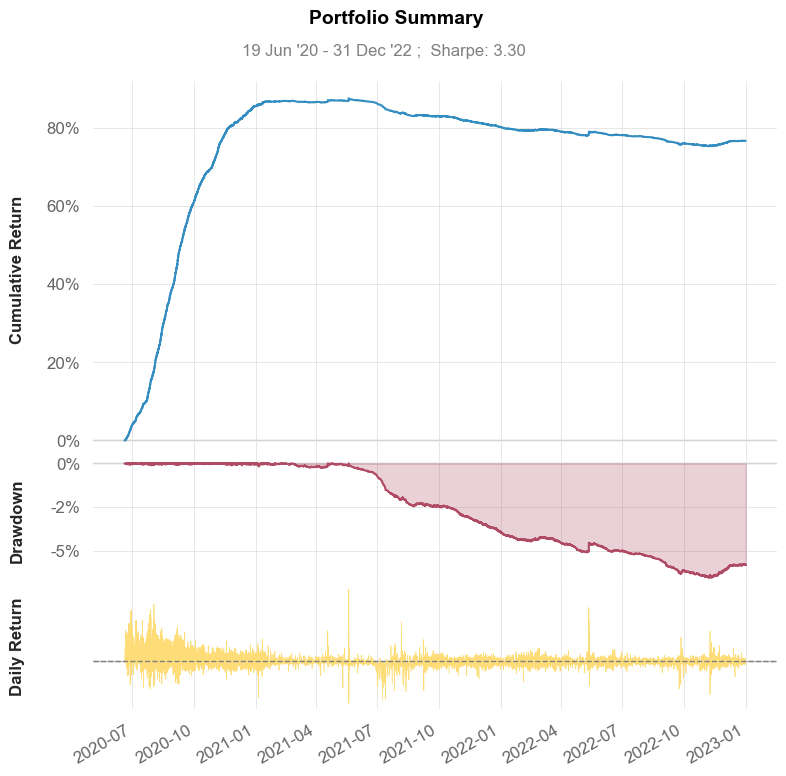

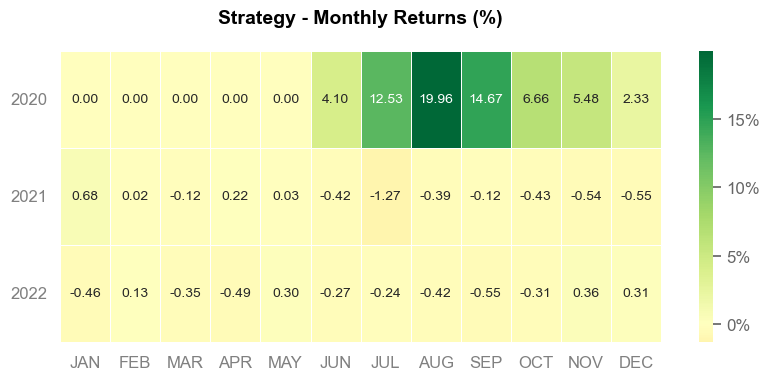

In [13]:
qs.reports.basic(best_return['returns'])

### Analyze the test result

In [14]:
test_return = get_return(result_path + test_files[0])
get_metrics(test_return)

Compound annual growth rate: 19%
Total orders count: 6502
Total long action: 2945
Total short action: 3557
Won orders count: 2945
Lost orders count: 3557
Win/Loss order ratio: 0.8279448973854372
Avg order pnl: 2.4278959163505484e-05
Avg order pnl won: 0.00015313194999091873
Avg order pnl lost: -8.240421710490386e-05
Avg long order pnl: -7.35803048901913e-05
Avg short order pnl: -7.529540506495332e-05


                    Strategy
------------------  ----------
Start Period        2023-01-01
End Period          2023-11-30
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   17.09%
CAGR﹪              12.68%

Sharpe              2.38
Prob. Sharpe Ratio  100.0%
Sortino             4.01
Sortino/√2          2.84
Omega               1.54

Max Drawdown        -1.65%
Longest DD Days     174

Gain/Pain Ratio     3.4
Gain/Pain (1M)      7.8

Payoff Ratio        1.86
Profit Factor       1.54
Common Sense Ratio  2.51
CPC Index           1.3
Tail Ratio          1.63
Outlier Win Ratio   3.07
Outlier Loss Ratio  3.9

MTD                 5.3%
3M                  13.67%
6M                  18.79%
YTD                 17.09%
1Y                  17.09%
3Y (ann.)           12.68%
5Y (ann.)           12.68%
10Y (ann.)          12.68%
All-time (ann.)     12.68%

Avg. Drawdown       -0.01%
Avg. Drawdown Days  1
Recovery Factor     9.59
Ulcer Index         0.01
Serenity Index      0.27


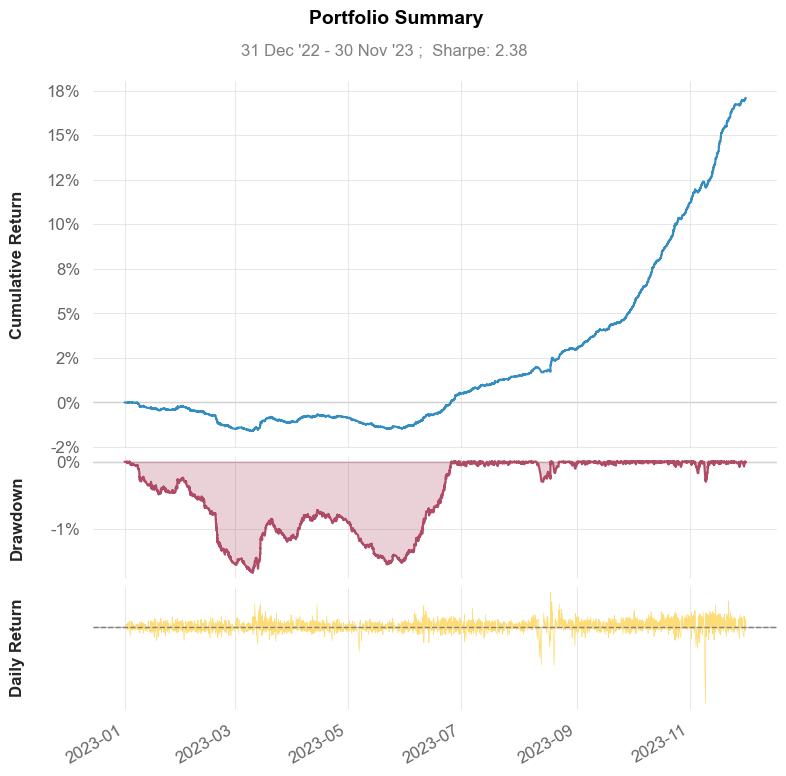

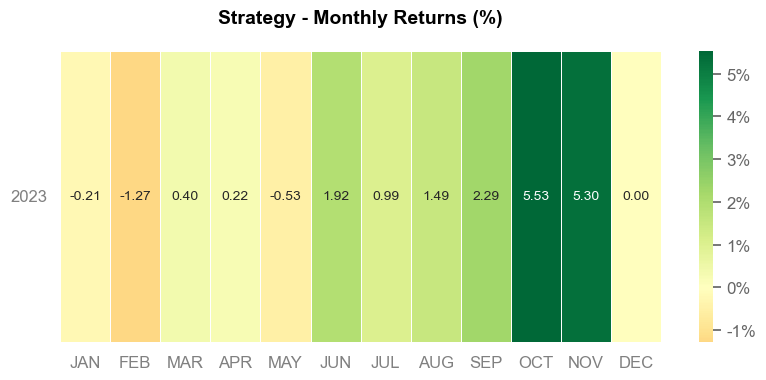

In [15]:
qs.reports.basic(test_return['returns'])